#Reconnaissance d’Entité Nommée (NER) - Rendu 2 - Gabriel Reynes

## Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import sklearn

In [18]:
!pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite
from sklearn_crfsuite import CRF, metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MeMartijn/updated-sklearn-crfsuite.git to /tmp/pip-install-mfyww6ve/sklearn-crfsuite_f151a831a73e4bcb8836eb2fc39b53c1
  Running command git clone -q https://github.com/MeMartijn/updated-sklearn-crfsuite.git /tmp/pip-install-mfyww6ve/sklearn-crfsuite_f151a831a73e4bcb8836eb2fc39b53c1


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## The dataset

In [20]:
def _generate_examples(filepath):
        with open(filepath, encoding="utf-8") as f:
            sent = []
            for line in f:
                if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                    if sent:
                        yield sent
                        sent = []
                else:
                    splits = line.split(" ")
                    token = splits[0]
                    pos_tag = splits[1]
                    ner_tag = splits[3].rstrip()
                    if 'MISC' in ner_tag:
                        ner_tag = 'O'
                    
                    sent.append((token, pos_tag, ner_tag))

In [21]:
%%time
train_sents = list(_generate_examples('NER Dataset/train.txt'))
test_sents = list(_generate_examples('NER Dataset/test.txt'))

CPU times: user 239 ms, sys: 31 ms, total: 270 ms
Wall time: 277 ms


In [22]:
# reduced features
def reduced_word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'w':word.lower(),
    }
    
    return sent[i][0].lower()

In [23]:
# sophisticated features
def sophisticated_word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


In [24]:
def sent2features(sent):
    return [reduced_word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [25]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 396 ms, sys: 20.9 ms, total: 417 ms
Wall time: 441 ms


In [26]:
X_test[2]

['al-ain', ',', 'united', 'arab', 'emirates', '1996-12-06']

In [27]:
y_test[2]

['I-LOC', 'O', 'I-LOC', 'I-LOC', 'I-LOC', 'O']

## Baseline Model (CRF)

In [28]:
%%time
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

try: # https://stackoverflow.com/questions/66059532/attributeerror-crf-object-has-no-attribute-keep-tempfiles
    crf.fit(X_train, y_train)
except AttributeError:
    pass

CPU times: user 16.2 s, sys: 93.3 ms, total: 16.3 s
Wall time: 19.9 s


In [29]:
y_pred = crf.predict(X_test)

In [30]:
labels = list(crf.classes_)
labels

['I-ORG', 'O', 'I-PER', 'I-LOC', 'B-LOC', 'B-ORG']

In [31]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.8024228725375101

In [32]:
# Group B and I label
y_test2 = [item if len(item)==1 else item[2:] for sublist in y_test for item in sublist]
y_pred2 = [item if len(item)==1 else item[2:] for sublist in y_pred for item in sublist]

labels2 =list(np.unique(y_test2))
labels2.remove('O')

print(sklearn.metrics.classification_report(y_test2, y_pred2, labels=labels2, digits=3))

              precision    recall  f1-score   support

         LOC      0.296     0.104     0.154      1925
         ORG      0.303     0.087     0.135      2496
         PER      0.440     0.100     0.162      2773

   micro avg      0.343     0.096     0.151      7194
   macro avg      0.347     0.097     0.151      7194
weighted avg      0.354     0.096     0.151      7194



## RNN Model

In [34]:
def lengths(data):
    return max([len(sent) for sent in data])

max_length = lengths(X_train)

In [42]:
from tensorflow.keras.layers import TextVectorization

X_vectorizer = TextVectorization(standardize=None,
                                 split="whitespace",
                                 output_mode="int",
                                 output_sequence_length=max_length)

x_ = [' '.join(sent) for sent in X_train]
X_vectorizer.adapt(x_)
X_train_enc = X_vectorizer(x_)

x_ = [' '.join(sent) for sent in X_test]
X_test_enc = X_vectorizer(x_)

In [43]:
vocabulary = X_vectorizer.get_vocabulary()

In [44]:
y_vectorizer = TextVectorization(standardize=None,
                                 split="whitespace",
                                 output_mode="int",
                                 output_sequence_length=max_length)

x_ = [' '.join(sent) for sent in y_train]
y_vectorizer.adapt(x_)
y_train_enc = y_vectorizer(x_)

x_ = [' '.join(sent) for sent in y_test]
y_test_enc = y_vectorizer(x_)

In [45]:
labels = y_vectorizer.get_vocabulary()

In [46]:
# Constants
vocab_size = len(vocabulary)
nb_labels = len(labels)

max_len = 10  # Sequence length to pad the outputs to.
embedding_dim = 50
lstm_hidden = 100

In [47]:
# define the model
input_ = layers.Input(shape=(max_length,), dtype=tf.int32)
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Embedding")(input_)
x = layers.LSTM(lstm_hidden, return_sequences=True, name="hidden")(x)
output_ = layers.Dense(nb_labels, activation='softmax')(x)
model = Model(input_, output_)
# summarize the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 Embedding (Embedding)       (None, 30, 50)            1050550   
                                                                 
 hidden (LSTM)               (None, 30, 100)           60400     
                                                                 
 dense_1 (Dense)             (None, 30, 8)             808       
                                                                 
Total params: 1,111,758
Trainable params: 1,111,758
Non-trainable params: 0
_________________________________________________________________


In [49]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=10, verbose=1, mode='max', restore_best_weights=True)
                 ]

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train_enc, y_train_enc, validation_split=0.2,
                 epochs=1000, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/1000
45/45 [==============================] - 10s 174ms/step - loss: 1.1981 - accuracy: 0.6861 - val_loss: 0.6895 - val_accuracy: 0.8678
Epoch 2/1000
45/45 [==============================] - 7s 160ms/step - loss: 0.4912 - accuracy: 0.8858 - val_loss: 0.4193 - val_accuracy: 0.9163
Epoch 3/1000
45/45 [==============================] - 7s 162ms/step - loss: 0.3466 - accuracy: 0.9215 - val_loss: 0.3301 - val_accuracy: 0.9297
Epoch 4/1000
45/45 [==============================] - 7s 161ms/step - loss: 0.2852 - accuracy: 0.9277 - val_loss: 0.2841 - val_accuracy: 0.9320
Epoch 5/1000
45/45 [==============================] - 7s 160ms/step - loss: 0.2385 - accuracy: 0.9312 - val_loss: 0.2407 - val_accuracy: 0.9339
Epoch 6/1000
45/45 [==============================] - 7s 159ms/step - loss: 0.1932 - accuracy: 0.9346 - val_loss: 0.2042 - val_accuracy: 0.9362
Epoch 7/1000
45/45 [==============================] - 8s 189ms/step - loss: 0.1561 - accuracy: 0.9431 - val_loss: 0.1819 - val_accuracy

In [50]:
y_pred_enc = model.predict(X_test_enc)
y_pred_enc = np.argmax(y_pred_enc, axis=2)

108/108 [==============================] - 1s 10ms/step


In [51]:
labels = ['[PAD]']+labels[1:]
labels_id = [i for i, _ in enumerate(labels)]
labels, labels_id

(['[PAD]', '[UNK]', 'O', 'I-PER', 'I-ORG', 'I-LOC', 'B-ORG', 'B-LOC'],
 [0, 1, 2, 3, 4, 5, 6, 7])

In [52]:
sklearn.metrics.f1_score(tf.reshape(y_test_enc, [-1]), tf.reshape(y_pred_enc, [-1]), average='weighted')

0.9593919196948972

In [53]:
# Group B and I label
y_test2 = [-1 if item<3 else item%3 for sublist in y_test_enc for item in sublist]
y_pred2 = [-1 if item<3 else item%3 for sublist in y_pred_enc for item in sublist]

labels2 =list(np.unique(y_test2))
labels2.remove(-1)

print(sklearn.metrics.classification_report(y_test2, y_pred2,
                                            target_names=["LOC", "PER", "ORG"],
                                            labels=labels2, digits=3))

              precision    recall  f1-score   support

         LOC      0.915     0.558     0.694      2540
         PER      0.538     0.440     0.484      2375
         ORG      0.674     0.760     0.714      1820

   micro avg      0.694     0.571     0.626      6735
   macro avg      0.709     0.586     0.631      6735
weighted avg      0.717     0.571     0.625      6735



## RNN Model with Attention

In [62]:
# define the model
input_ = layers.Input(shape=(max_length,), dtype=tf.int32)
encoder_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="vocab_embedding")(input_)
encoder_outputs, encoder_state_h, encoder_state_c = layers.LSTM(lstm_hidden, return_sequences=True, return_state=True, name="hidden")(encoder_embedding)

# We discard `encoder_outputs` and only keep the states. 
encoder_states = [encoder_state_h, encoder_state_c]

print(encoder_outputs.shape)

(None, 30, 100)


In [63]:
""" Decoder part """
# Set up the decoder, using `encoder_states` as initial state. 
decoder_inputs = layers.Input(shape=(None,), dtype=tf.int32, name="label_input")
decoder_embedding = layers.Embedding(nb_labels, embedding_dim,
                                     name="label_embedding")(decoder_inputs)
decoder_outputs, decoder_state_h, decoder_state_c = layers.LSTM(lstm_hidden, return_sequences=True, return_state=True, name="Decoder")(decoder_embedding, initial_state=encoder_states)

print(decoder_outputs.shape)

(None, None, 100)


In [64]:
""" Attentional part """
# We use all encoder ouput
attention = layers.dot([decoder_outputs, encoder_outputs], axes=[2,2], name="Attention_score")
attention = layers.Activation('softmax', name="Attention_weight")(attention)
print(attention.shape)

(None, None, 30)


In [65]:
""" Context vector """
context = layers.dot([attention, encoder_outputs], axes=[2,1], name="Attention_output")
print(context.shape)

(None, None, 100)


In [66]:
""" Combine attention with decoder ouput """
decoder_combined_context = layers.concatenate([context, decoder_outputs], name="Luong_Attention")
print(decoder_combined_context.shape)

(None, None, 200)


In [68]:
""" Ouput of the model """
decoder_outputs = layers.Dense(nb_labels, activation='softmax', name="Output")(decoder_combined_context)
print(decoder_outputs.shape)

(None, None, 8)


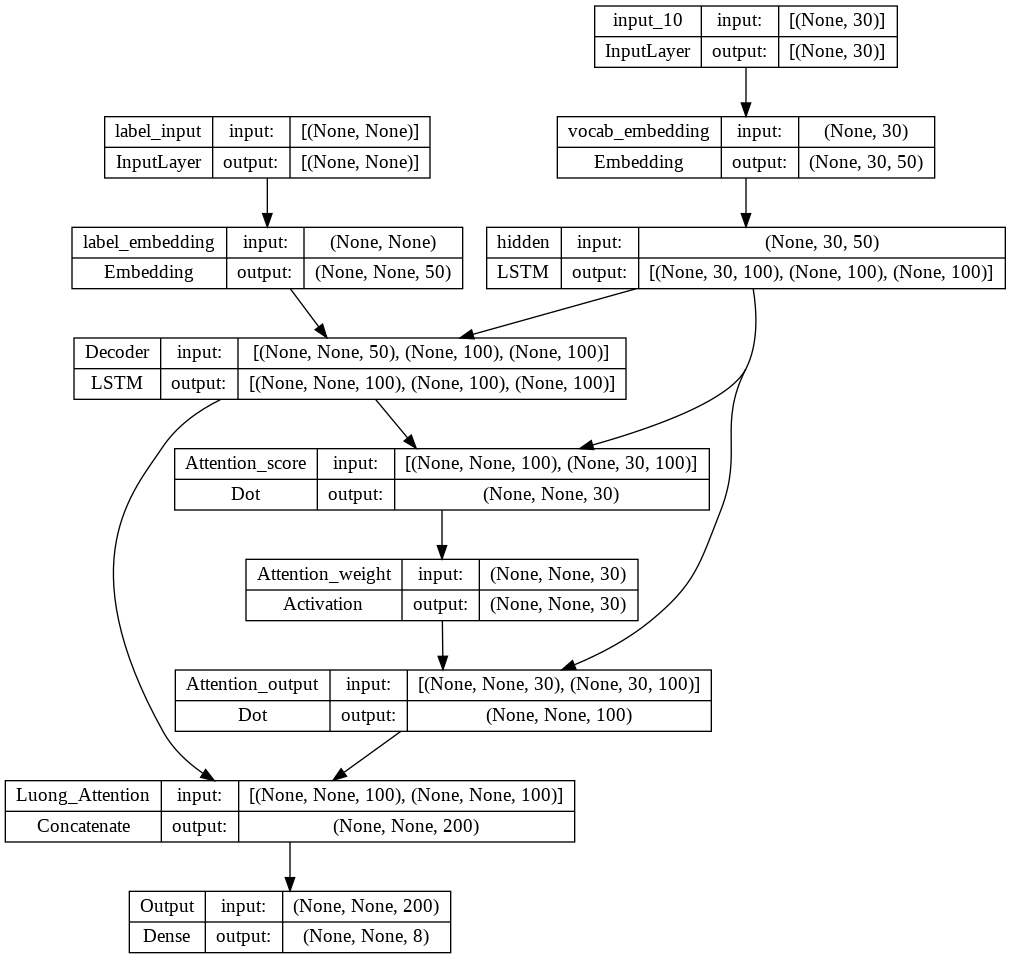

In [70]:
""" The model """
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([input_, decoder_inputs], decoder_outputs)

plot_model(model, show_shapes=True)

In [100]:
x_ = [' '.join(sent) for sent in y_train]
y_vectorizer.adapt(x_)
y_teacher_enc = y_vectorizer(x_)
y_target_enc = np.zeros_like(y_teacher_enc)
y_target_enc[:,:-1] = y_teacher_enc[:,1:]
y_teacher_enc.shape

TensorShape([14041, 30])

In [80]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit([X_train_enc, y_teacher_enc], y_target_enc, validation_split=0.2,
                 epochs=1000, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/1000
45/45 [==============================] - 21s 376ms/step - loss: 0.9164 - accuracy: 0.7865 - val_loss: 0.4154 - val_accuracy: 0.8914
Epoch 2/1000
45/45 [==============================] - 16s 349ms/step - loss: 0.3212 - accuracy: 0.9117 - val_loss: 0.3105 - val_accuracy: 0.9172
Epoch 3/1000
45/45 [==============================] - 15s 336ms/step - loss: 0.2677 - accuracy: 0.9286 - val_loss: 0.2781 - val_accuracy: 0.9213
Epoch 4/1000
45/45 [==============================] - 17s 388ms/step - loss: 0.2602 - accuracy: 0.9273 - val_loss: 0.2631 - val_accuracy: 0.9284
Epoch 5/1000
45/45 [==============================] - 17s 372ms/step - loss: 0.2419 - accuracy: 0.9352 - val_loss: 0.2587 - val_accuracy: 0.9295
Epoch 6/1000
45/45 [==============================] - 16s 354ms/step - loss: 0.2339 - accuracy: 0.9367 - val_loss: 0.2515 - val_accuracy: 0.9319
Epoch 7/1000
45/45 [==============================] - 16s 355ms/step - loss: 0.2281 - accuracy: 0.9375 - val_loss: 0.2517 - val_ac

In [118]:
x_ = [' '.join(sent) for sent in y_test]
y_vectorizer.adapt(x_)
y_teacher_enc = y_vectorizer(x_)
y_teacher_enc.shape

TensorShape([3453, 30])

In [119]:
y_pred_enc = model.predict([X_test_enc, y_teacher_enc])
y_pred_enc = np.argmax(y_pred_enc, axis=2)

108/108 [==============================] - 2s 20ms/step


In [120]:
sklearn.metrics.f1_score(tf.reshape(y_test_enc, [-1]), tf.reshape(y_pred_enc, [-1]), average='weighted')

0.8806754182854544

In [121]:
# Group B and I label
y_test2 = [-1 if item<3 else item%3 for sublist in y_test_enc for item in sublist]
y_pred2 = [-1 if item<3 else item%3 for sublist in y_pred_enc for item in sublist]

labels2 =list(np.unique(y_test2))
labels2.remove(-1)

print(sklearn.metrics.classification_report(y_test2, y_pred2,
                                            target_names=["LOC", "PER", "ORG"],
                                            labels=labels2, digits=3))

              precision    recall  f1-score   support

         LOC      0.552     0.126     0.205      2540
         PER      1.000     0.045     0.085      2375
         ORG      1.000     0.001     0.001      1820

   micro avg      0.622     0.063     0.115      6735
   macro avg      0.851     0.057     0.097      6735
weighted avg      0.831     0.063     0.108      6735

